In [8]:
import sys
sys.path.append('../')

from helpers import helper
from dataloaders import dataloader
from networks import Unet

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

trainset, train_dl = dataloader.getData('../../datasets/train.csv', batch_size=4)


tensor([1.], device='mps:0')


In [5]:
network = Unet.getModel()

torch.Size([4, 3, 256, 256])
torch.Size([4, 2, 256, 256])
loss: 281024.21875


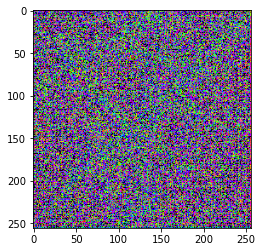

In [11]:
def test(decoder, test_dl):
    decoder.to(mps_device)
    for images, labels in train_dl:
        images = images.to(mps_device)
        labels = labels.to(mps_device)
        print(images.shape)
        outputs = decoder(images)
        label_HSV = helper.convertXYtoHSV(outputs[0].cpu().detach().permute(1,2,0).numpy())
        plt.imshow(cv2.cvtColor(label_HSV, cv2.COLOR_HSV2RGB))  
        print(outputs.shape)
        break

    loss = nn.MSELoss(reduction='sum')(outputs, labels)
    loss.backward()
    print(f'loss: {loss.item()}')
    
test(network, train_dl)